# AutoEncoder, Variational AutoEncoder and GAN

In [1]:
import numpy as np
import torch
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
from typing import Sequence
import datetime
import copy
from os import listdir

## General instructions

Every two weeks you will be given an assignment related to the associated module. There are 3 weekly group sessions available to help you complete the assignments, you are invited to attend one of them each week. Attendance is not mandatory but recommended. However, assignments are graded and not submitting them or submitting them after the deadline will give you no points. The grading system is detailed [here](https://mitt.uib.no/courses/27468/pages/general-information)

**FORMAT**: Jupyter notebook    
**DEADLINE**: Sunday 16th May, 23:59

## Introduction

In this assignment we will go through 3 types of unsupervised neural network: AutoEncoder (AE), Variational AutoEncoder (VAE) and Generative Adversarial Network (GAN). In the first section we will also introduce a new type of layer: the transpose convolution as it is widely used in these unsupervised methods.

Unsupervised have many advantages including the fact that they don't need labels but they are also harder to train... In this assignment it will be totally okay if you don't get good results, we will provide examples of expected results and we don't expect you to spend the entire 2 weeks on the parameter tuning.

## Contents

1. Transpose convolution
2. AutoEncoder
3. Variational AutoEncoder
4. GAN

## Related videos from the curriculum

- [Lecture 15.1 — From PCA to autoencoders](https://www.youtube.com/watch?v=PSOt7u8u23w&list=PLLssT5z_DsK_gyrQ_biidwvPYCRNGI3iv&index=69)
- [Lecture 15.2 — Deep autoencoders](https://www.youtube.com/watch?v=6jhhIPdgkp0&list=PLLssT5z_DsK_gyrQ_biidwvPYCRNGI3iv&index=70) 
- [Lecture 15.3 — Deep autoencoders for document retrieval](https://www.youtube.com/watch?v=ZCNbjpcX0yg&list=PLLssT5z_DsK_gyrQ_biidwvPYCRNGI3iv&index=71)
- [Lecture 15.6 — Shallow autoencoders for pre training](https://www.youtube.com/watch?v=xjlvVfEbhz4&list=PLLssT5z_DsK_gyrQ_biidwvPYCRNGI3iv&index=74)
- [Lecture 13 | Generative Models]


# 2. (Reminders) Encoder and Decoder

### Modules 

In the cell below are defined the following modules that we will need in this section

1. **MyEncoder**
    - input: image
    - output: tensor `z` in latent space (lower dimension than input space)
1. **MyDecoder**
    - input: tensor `z` in latent space (lower dimension than image space)
    - output: reconstructed image


In [2]:
class MyEncoder(nn.Module):
    """
    Encoder module: 
    - input: image
    - output: tensor `z` in latent space (lower dimension than input space)
    """

    def __init__(self, z_dim):
        super().__init__() 
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=6, stride=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=5, kernel_size=5, stride=1)
        self.conv3 = nn.Conv2d(in_channels=5, out_channels=4, kernel_size=4, stride=1)
        self.fc3 = nn.Linear(in_features=256, out_features=z_dim)
        
    def forward(self, x):
        N = x.shape[0]
        out = torch.relu(self.conv1(x))
        out = torch.relu(self.conv2(out))
        out = torch.relu(self.conv3(out))
        out = out.view(N, -1)
        out = torch.relu(self.fc3(out))
        return out

class MyDecoder(nn.Module):
    """
    Decoder module: 
    - input: tensor `z` in latent space (lower dimension than image space)
    - output: reconstructed image
    """
    def __init__(self, z_dim):
        super().__init__() 
        c1 = 3
        self.fc1 = nn.Linear(z_dim, 128)
        self.fc2 = nn.Linear(128, 18*18)
        self.transconv3 = nn.ConvTranspose2d(in_channels=1, out_channels=1,  kernel_size=3, stride=1)
        
        
    def forward(self, x):
        N, z_dim = x.shape
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = out.view(N, 1, 18, 18)
        out = torch.sigmoid(self.transconv3(out))
        return out

### Utils 

Some useful functions:

- **load_MNIST**: Return MNIST train and val dataset
- **plot_true_VS_reconstructed**: Plot side by side original images with their reconstructed counterparts using a trained VAE
- **plot_generated_images**: Plot images generated by a VAE
- **training_vae**: Training loop for a VAE

In [3]:
preprocessor = transforms.Compose([
    transforms.CenterCrop(20),
    transforms.ToTensor(),
    transforms.Normalize(0.2475, 0.3892),
]) 


def load_MNIST(data_path='../data/', transform = preprocessor, labels_kept=[0,1,3,4,8]):
    """
    Return MNIST train and val dataset
    """
    MNIST_train = datasets.MNIST(
        data_path,       
        train=True,      
        download=True,   
        transform=transform
    )

    MNIST_val = datasets.MNIST(
        data_path, 
        train=False,      
        download=True,   
        transform=transform
    )

    print('Size of the original training dataset: ', len(MNIST_train))
    print('Size of the original validation dataset: ', len(MNIST_val))

    if len(labels_kept) <10:
        MNIST_train_reduced = [(img, labels_kept.index(label)) for img, label in MNIST_train if label in labels_kept]
        MNIST_val_reduced = [(img, labels_kept.index(label)) for img, label in MNIST_val if label in labels_kept]

        print('Size of the reduced training dataset: ', len(MNIST_train_reduced))
        print('Size of the reduced validation dataset: ', len(MNIST_val_reduced))
    else:
        MNIST_train_reduced = MNIST_train
        MNIST_val_reduced = MNIST_val

    return MNIST_train_reduced, MNIST_val_reduced

def plot_true_VS_reconstructed(ae, imgs):
    """
    Plot side by side original images with their reconstructed counterpart using a trained VAE
    """
    ae.eval()
    N_img = 25
    fig, axs = plt.subplots(nrows=5, ncols=10, figsize=(10,6), sharex=True, sharey=True)
    for i, img in enumerate(imgs[:N_img]):
        with torch.no_grad():
            out = ae(img.unsqueeze(0))
            # True image
            axs.flat[2*i].imshow(img.permute(1, 2, 0), cmap='Greys')
            # Reconstruction
            axs.flat[2*i + 1].imshow(out.squeeze(0).permute(1, 2, 0), cmap='Greys') 
            # Set ax title for the first row
            if i<5:
                axs.flat[2*i].set_title("True\nimage")
                axs.flat[2*i + 1].set_title("AE recon-\nstruction")
    return fig, axs

def plot_generated_images(vae):
    """
    Plot images generated by a VAE
    """
    vae.eval()
    N_img = 100
    fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(13,13), sharex=True, sharey=True, tight_layout=True)
    fig.suptitle("Image generation", fontsize=15)
    for i in range(N_img):
        with torch.no_grad():
            a_z = torch.randn(1,vae.z_dim)
            a_img = vae.decoder(a_z)
            axs.flat[i].imshow(a_img[0].permute(1, 2, 0), cmap='Greys')
    return fig, axs

def training_vae(n_epochs, optimizer, model, loss_fn, train_loader, kld_weight=None, device=None):
    """
    Training loop for a VAE
    """
    if device is None:
        device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
    if kld_weight is None:
        kld_weight = torch.ones(n_epochs)
    model.train()
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        loss_train_mse = 0.
        loss_train_kld = 0.

        for imgs in train_loader:

            imgs = imgs.to(device=device) 

            outputs = model(imgs)
            mse_loss, kld_loss = loss_fn(outputs, imgs, model.mu, model.logvar)
            # Final loss is the sum of the 2 terms (with potentially a weight term)
            loss = mse_loss + kld_weight[epoch-1]*kld_loss
        
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_train += loss.item()
            loss_train_mse += mse_loss.item()
            loss_train_kld += kld_loss.item()

        
        if epoch == 1 or epoch % 1 == 0:
            print('{}  |  Epoch {}  |  Training loss {:.3f}  |  MSE loss {:.3f}  |  KLD loss {:.12f}'.format(
                datetime.datetime.now(), 
                epoch,
                loss_train / len(train_loader),
                loss_train_mse / len(train_loader),
                loss_train_kld / len(train_loader),
            ))


In [4]:
# Load the data

# It's already hard enough to train VAE, a subset of MNIST will be more than enough.
labels_kept = [0,1,3,4,8]
data_train, data_val = load_MNIST(labels_kept=labels_kept)
imgs_train = [img for img, _ in data_train]
imgs_val = [img for img, _ in data_val]

Size of the original training dataset:  60000
Size of the original validation dataset:  10000
Size of the reduced training dataset:  30489
Size of the reduced validation dataset:  5081


# 3. Variational AutoEncoder

*related videos from the curriculum*

- [Lecture 13 | Generative Models](https://www.youtube.com/watch?v=5WoItGTWV54&list=PL3FW7Lu3i5JvHM8ljYj-zLfQRF3EO8sYv&index=17) 
  - from 27:05 to 31:05: Introducting VAE 
  - *Let's forget about tractability :) *
  - from 40:55 to 44:00: VAE loss and VAE training
  - from 44:00 to 49:00: Generating data using VAE and summary 

**Introduction to VAE**

A Variational AutoEncoder (VAE) is a neural network that is similar to a AE in its structure as it is composed of 2 sub-networks: an Encoder and a Decoder. However now our main objective is not to efficiently represent some data lying on a non-linear manifold anymore. Instead we aim at generating some new data that would look like the training data but that is just a simple copy of a training input! We want **new** data.

To do so, we want our model to first get a good representation of what real data look like and then to be able to generate new plausible instances. The *get a good representation* part seems to be similar to what an Encoder can do and the *generate plausible instances* part to what a Decoder can do. However we can not really *generate new* data with a Decoder but just *reconstruct*. The *generate* part is actually what makes VAE different from AE and it is achieved in 2 steps: 

- a reparameterization step in the forward pass between the Encoder and Decoder
- a KL-divergence term added to the loss function 

These 2 steps aim at forcing the elements of latent space to look like normally distributed samples. Once the training is finished, this forcing will allow us to generate new data by simply giving a random normally distributed sample to the Decoder (and the Encoder can be thrown away, so this is the opposite of AE where we could throw away the Decoder and keep the Encoder).

**Reparameterization**

The reparameterization consists in defining the latent vector ``z`` not as the output of the encoder but as a random sample from $\mathcal{N}$(``mu``, ``std``$)$ where ``mu`` and ``std`` are the actual outputs of the Encoder (for computational reasons the Encoder actually returns ``mu`` and ``logvar (=log(std**2))``)

**KL-divergence**

The second difference between a VAE and an AE is in the loss function. In addition to the reconstruction term we want to force the Encoder to learn the parameters of a normal distribution. There exists a measure for that, the Kullback–Leibler divergence or simply KL-divergence ([Wikipedia](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence), [PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.KLDivLoss.html?highlight=kld#torch.nn.KLDivLoss)). The KL-divergence measures how one probability distribution $P$ is different from a second $Q$ by computing the following:

$$D_{KL}(P||Q) = \int_{-\infty}^{+\infty} p(x)log\Big(\frac{p(x)}{q(x)}\Big) \,dx \$$

Where $p$ and $q$ are the probability densities of the probability distributions $P$ and $Q$. This measure can be used for different purposes and have as many interpretations (see [Interpretations](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence#Interpretations) section from the Wikipedia page) but in the context of Variational AutoEncoder we will interpret $Q$ as our prior and $P$ as our *true* distribution and $D_{KL}(P||Q)$ can then be interpreted as the information lost when our prior $Q$ is used to approximate $P$. In our very specific case where $Q \sim \mathcal{N}(0, 1)$ and $P \sim \mathcal{N}$(``mu``, ``std``$)$, $D_{KL}(P||Q)$ can be formulated as follows (see [Multivariate normal distributions](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence#Multivariate_normal_distributions) section from the Wikipedia page):

$$D_{KL}(P||Q) = \frac{1}{2} \sum_{i=1}^k \Big( \sigma_i^2 + \mu_i^2 -1 -log(\sigma_i^2) \Big) \qquad \text{with std} = \begin{bmatrix}\sigma_0 \cdots \sigma_{z_{dim}-1} \end{bmatrix} \quad \text{and mu} = \begin{bmatrix}\mu_0 \cdots \mu_{z_{dim}-1} \end{bmatrix}  $$


--------------------
## TODO

### MyVAE class: A variational AutoEncoder

Complete the ``MyVAE`` class below (that is the variational counterpart of the ``MyAE`` class implemented in section 2). Normally you don't have to re-implement an encoder and a decoder, you can simply use the ``MyEncoder`` and the ``MyDecoder`` classes.  (defined at the beginning of this notebook as well). However a few details must be adapted:

1. Encoder must return 2 tensors of shape ``(N, z_dim)``: one for ``mu`` and one for ``logvar (=log(std**2))`` **or equivalently** use ``MyEncoder`` with ``z_dim = 2*z_dim`` and then define ``mu`` and ``logvar`` in the forward method as follows: 

  ```
  self.mu_logvar = self.encoder(x)               # Output of the encoder, shape=(N, 2*z_dim)
  self.mu = self.mu_logvar[:,:self.z_dim]        # mu                   , shape=(N, z_dim)   (1st half of the encoded vector)
  self.logvar = self.mu_logvar[:,self.z_dim:]    # logvar               , shape=(N, z_dim)   (2nd half of the encoded vector)
  ```

2. On top of returning the reconstructed image, the forward pass of your VAE must store ``mu`` and ``log`` (as suggested in the lines above) because we'll need them when computing the KL-divergence term of the loss function.

3. A ``reparameterization`` method must be added that draws a sample $z$ (of shape ``(N, z_dim)``) from $\mathcal{N}(0,1)$ and return $z*std + mu$ so that it corresponds to a sample from $\mathcal{N}$(``mu``, ``std``$)$ (Reminder: ``logvar = log(std**2))`` so ``std = 1/2 * exp(logvar)``). **Hint** you can use [torch.randn](https://pytorch.org/docs/stable/generated/torch.randn.html?highlight=randn#torch.randn) or [torch.randn_like](https://pytorch.org/docs/stable/generated/torch.randn_like.html?highlight=randn#torch.randn_like) or [torch.nn.init.normal_](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.normal_). This method is to be called between the Encoder and the Decoder both during the training and can also be thrown away once the training is complete.

4. Decoder is exactly same as for an AutoEncoder

5. Write a ``generate_images`` method that takes as parameter an integer ``N_imgs`` defining the number of images to generate and returns ``imgs_generated`` (shape ``(N_imgs, C_in, H_in, W_in)``) the images generated by the VAE. **Hint** you can use [torch.randn](https://pytorch.org/docs/stable/generated/torch.randn.html?highlight=randn#torch.randn)

### loss_VAE: A loss adapted to VAE

Complete the ``loss_VAE`` function below where 
- ``inputs`` is the original images (shape ``(N, C_in, H_in, W_in)``)
- ``outputs`` is the reconstructed images (shape ``(N, C_in, H_in, W_in)``), 
- ``mu`` and ``logvar (=log(std**2)`` are the outputs of the Encoder representing the parameters of our normal distribution $P$  (both of shape ``(N, z_dim)``)). 

It returns the 2 terms of the VAE loss function:
- ``mse_loss``, the reconstruction term. **Hint** you can use [F.mse_loss](https://pytorch.org/docs/stable/nn.functional.html?highlight=mse_loss#torch.nn.functional.mse_loss) with ``reduction="mean"``
- ``kld_loss``, the KL-divergence term. which is defined in the cell above. To adapt formula to batch computations, we need to re-write it as follows:

$$D_{KL}(P||Q) =\text{mean}\Big( \frac{1}{2} \sum_{i=1}^k \Big( \sigma_{:,i}^2 + \mu_{:,i}^2 -1 -log(\sigma_{:,i}^2) \Big) \Big) \qquad \text{with std} = \begin{bmatrix}\sigma_{:,0} \cdots \sigma_{:, z_{dim}-1} \end{bmatrix} \quad \text{and mu} = \begin{bmatrix}\mu_{:,0} \cdots \mu_{:, z_{dim}-1} \end{bmatrix}  $$




In [30]:
class MyVAE(nn.Module):

    def __init__(self, z_dim):
        super().__init__() 
        # Latent space dimension
        self.z_dim = z_dim
        # Encoder similar to what we used for the AE but used to encode both mu and logvar 
        # TODO Write custom encoder to simplify class
        self.encoder = MyEncoder(self.z_dim * 2)
        
        # There is no difference between a VAE and AE decoder
        self.decoder = MyDecoder(self.z_dim)

    def reparameterize(self):
        """
        Reparameterization: draw a sample z of shape (N, z_dim) (z~N(mu, logvar))

        mu and logvar should be accessible via self.mu and self.logvar
        """
        # Initialize a vector z with the right shape whose elements are drawn from a normal distribution N(0, 1)
        #TODO
        z = torch.Tensor(self.mu.shape[0], self.mu.shape[1])
        z = torch.randn_like(z)
        # Shift z so that it is equivalent to a sample drawn from N(mu, std)
        std = torch.exp(self.logvar)**(1/2)
        z = torch.add(torch.mul(z, std), self.mu)
        return z
        
    def forward(self, x):
        # Encode the data and output the estimated parameters mu and logvar
        self.mu_logvar = self.encoder(x)
        
        # mu can be defined as the first half of the encoder output
        self.mu = self.mu_logvar[:,:self.z_dim]
        # logvar can be defined as the second half of the encoder output
        self.logvar = self.mu_logvar[:,self.z_dim:]

        # Reparameterization: draw a sample z of shape (N, z_dim) (z~N(mu, logvar))
        # by calling the reparameterize method
        z = self.reparameterize()
        
        # Generate (decode) an image from the sample z
        out = self.decoder(z)
        return out

    def generate(self, N_imgs):
        """
        Generate new images by giving sampled latent vectors from N(0,1) to the decoder
        """
        imgs_generated = torch.Tensor(N_imgs, 3, 28, 28)
        imgs_generated = torch.randn(imgs_generated)
        imgs_generated = self.decoder(imgs_generated)
        return imgs_generated

KLDivLoss_fn = torch.nn.KLDivLoss(reduction='mean')
def loss_VAE(inputs, outputs, mu, logvar):
    """
    Loss for a VAE: a reconstruction term (mse loss) and a distribution term (kl divergence)
    """
    # Regular reconstruction term using the mse loss, same as what we used for the AutoEncoder
    mse_loss = torch.nn.functional.mse_loss(outputs, inputs, reduction='mean')

    
    # Distribution term: force the latent space to behave like a normal distribution
    # Special case of the KL divergence when the prior is Q~N(0,1) and P~N(mu, std)

    kld_loss = torch.mean(0.5 * torch.sum(torch.exp(logvar) + mu ** 2 - 1 - logvar, dim = 1), dim = 0)
    return mse_loss, kld_loss
                

### Training your Variational AutoEncoder

Run the cell below to train your VAE. You can play with the parameter if you want/need.
Keep in mind that training unsupervised model is not easy and that it is okay in this assignment if you don't get good results at all, we will provide examples of results so that you can still answer the questions).

In [28]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")
z_dim = 15

vae = MyVAE(z_dim=z_dim)
vae.to(device=device)

train_loader_imgs = torch.utils.data.DataLoader(imgs_train, batch_size=512, shuffle=True)
val_loader_imgs = torch.utils.data.DataLoader(imgs_val, batch_size=512, shuffle=True)

lr = 0.3
momentum = 0.7

optimizer = optim.SGD(vae.parameters(), lr=lr, momentum=momentum)
loss_fn = loss_VAE

training_vae(
    n_epochs = 30,
    optimizer = optimizer,
    model = vae,
    loss_fn = loss_fn,
    train_loader = train_loader_imgs,
    device=device,
)

Training on device cpu.
2021-05-13 16:22:58.387815  |  Epoch 1  |  Training loss 1.036  |  MSE loss 1.036  |  KLD loss 0.000758273755
2021-05-13 16:23:02.169528  |  Epoch 2  |  Training loss 1.013  |  MSE loss 1.013  |  KLD loss 0.000000000697
2021-05-13 16:23:05.986343  |  Epoch 3  |  Training loss 1.011  |  MSE loss 1.011  |  KLD loss 0.000000000648
2021-05-13 16:23:10.033743  |  Epoch 4  |  Training loss 1.009  |  MSE loss 1.009  |  KLD loss 0.000000000589
2021-05-13 16:23:13.914769  |  Epoch 5  |  Training loss 1.007  |  MSE loss 1.007  |  KLD loss 0.000000000575
2021-05-13 16:23:17.752662  |  Epoch 6  |  Training loss 1.004  |  MSE loss 1.004  |  KLD loss 0.000000000549
2021-05-13 16:23:21.594347  |  Epoch 7  |  Training loss 0.997  |  MSE loss 0.997  |  KLD loss 0.000000000530
2021-05-13 16:23:25.506674  |  Epoch 8  |  Training loss 0.982  |  MSE loss 0.982  |  KLD loss 0.000000000568
2021-05-13 16:23:29.433789  |  Epoch 9  |  Training loss 0.959  |  MSE loss 0.959  |  KLD loss 0

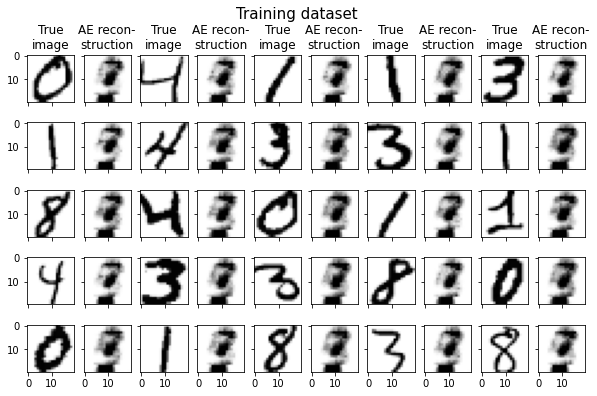

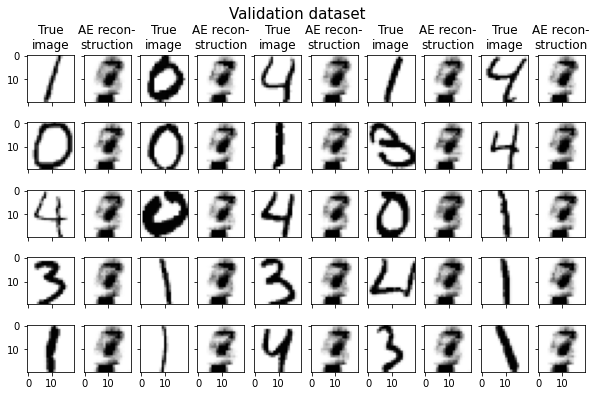

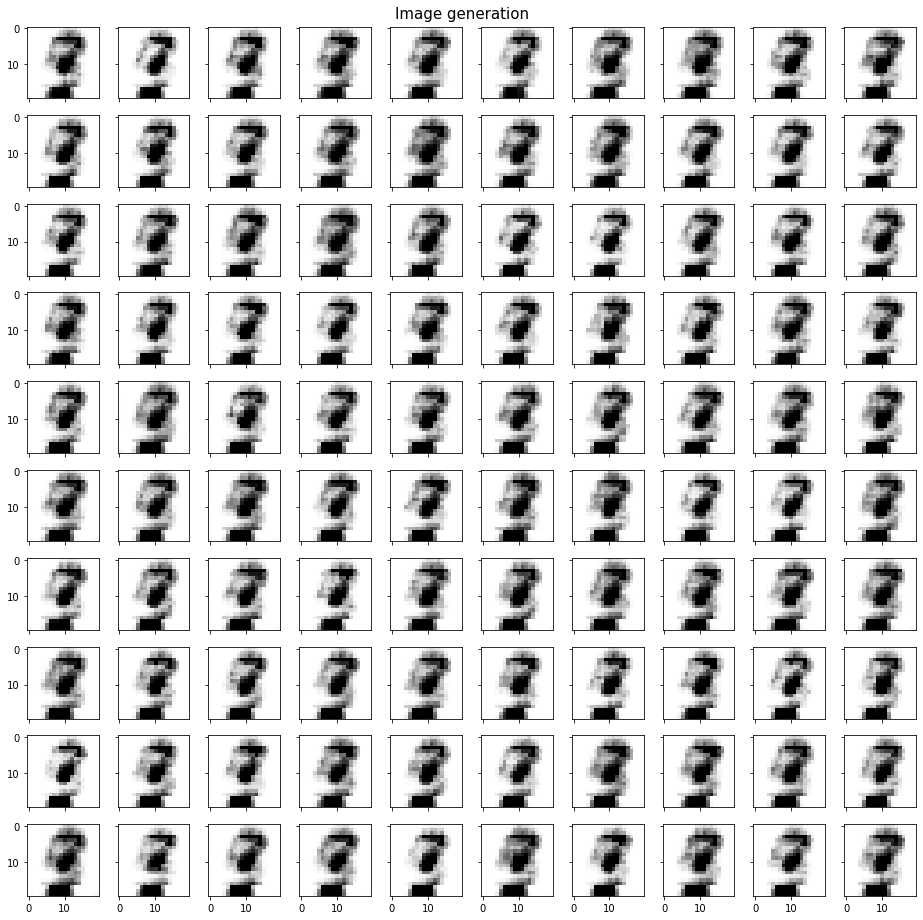

In [29]:
vae.to(device=torch.device('cpu')) 
fig, axs = plot_true_VS_reconstructed(vae, imgs_train)
fig.suptitle("Training dataset", fontsize=15)
plt.show()
fig, axs = plot_true_VS_reconstructed(vae, imgs_val)
fig.suptitle("Validation dataset", fontsize=15)
plt.show()
fig, axs = plot_generated_images(vae)
plt.show()

### Example training loss

![Example of VAE training loss (see VAE_vanilla_training_loss image)](./VAE_vanilla_training_loss.png)

--------------------
## TODO
Analyse the results in the image above.

1. Compare the evolution of the MSE loss with the KL-divergence loss and comment. MSE loss seems to stagnate as KL-divergence approaches zero
2. By looking at the loss what type of results do you expect? (Good reconstruction? Good distribution in the latent space?) The loss is currently too high to reconstruct good images
3. Recalling that for this assignment (and in its specific settings) we can say that our VAE learns well how to reconstruct if its training loss is lower than 0.6, would you say that the VAE is able to reconstruct well our data? Not currently, no

### Example reconstruction
![Example of VAE reconstruction results on the training dataset (see VAE_vanilla_train_reconstruction image)](./VAE_vanilla_train_reconstruction.png)

--------------------
## TODO
Analyse the results in the image above.

1. Comment the behavior of the VAE when reconstructing different images. The images are far too generalized
2. Mode collapse is a very common problem when training VAE (and other unsupervised method), can you explain what this problem is? The VAE over-optimizes for a certain feature, and is never able to learn itself away from it.

### Example generation
![Example of VAE generation results (see VAE_vanilla_generation image)](./VAE_vanilla_generation.png)

--------------------
## TODO
Analyse the results in the image above.

1. Do the generated images look similar to the outputs of the reconstructed images? The generated images are practically identical to the reconstructed images
1. Would you say that the VAE learnt well the parameters of a normal distribution? Yes, as the KL-divergence is almost 0. However, this is not a good metric for deciding if the model generates good examples

### Training your Variational AutoEncoder: with a weighted KLD loss

In order to fix the 'mode collapse' problem and to make sure our model learns to both reconstruct images and organize the latent space we will add a weight on the KL divergence term. We will first define this weight as extremely low so that the model learns first how to reconstruct and then we will increasingly amplify this weight so that the model re-organize the latent space properly. Once the weight is considered high enough we will stop increasing this weight let the model re-polish its reconstruction learning in this new organization. 

Run the cell below to train your VAE. You can play with the parameter if you want/need.
Keep in mind that training unsupervised model is not easy and that it is okay in this assignment if you don't get good results at all, we will provide examples of results so that you can still answer the questions).

Text(0.5, 1.0, 'KLD Weight term evolution thoughout the epochs ')

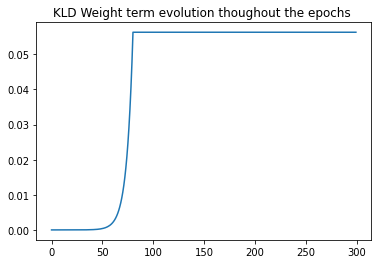

In [24]:
epochs = 300
kld_weight = torch.zeros(epochs)
kld_weight[0] = 0.0000001
for i in range(1,81):
     kld_weight[i] = kld_weight[i-1]*1.18
kld_weight[81:] = kld_weight[80]
plt.plot(np.arange(len(kld_weight)), kld_weight)
plt.title("KLD Weight term evolution thoughout the epochs ")

In [ ]:
vae = MyVAE(z_dim=z_dim)
vae.to(device=device)
optimizer = optim.SGD(vae.parameters(), lr=lr, momentum=momentum)

training_vae(
    n_epochs = epochs,
    optimizer = optimizer,
    model = vae,
    loss_fn = loss_fn,
    train_loader = train_loader_imgs,
    kld_weight = kld_weight,
)

2021-05-13 16:27:43.291631  |  Epoch 1  |  Training loss 1.037  |  MSE loss 1.037  |  KLD loss 0.135004506384
2021-05-13 16:27:47.407423  |  Epoch 2  |  Training loss 1.011  |  MSE loss 1.011  |  KLD loss 0.893478702257
2021-05-13 16:27:51.857399  |  Epoch 3  |  Training loss 0.998  |  MSE loss 0.998  |  KLD loss 605.786201063792
2021-05-13 16:27:56.038176  |  Epoch 4  |  Training loss 0.945  |  MSE loss 0.945  |  KLD loss 2779.151927693685
2021-05-13 16:28:00.218493  |  Epoch 5  |  Training loss 0.848  |  MSE loss 0.846  |  KLD loss 6819.934191894531
2021-05-13 16:28:04.679603  |  Epoch 6  |  Training loss 0.775  |  MSE loss 0.773  |  KLD loss 8079.134708658854
2021-05-13 16:28:09.003151  |  Epoch 7  |  Training loss 0.727  |  MSE loss 0.725  |  KLD loss 7246.936531575521
2021-05-13 16:28:13.362817  |  Epoch 8  |  Training loss 0.699  |  MSE loss 0.697  |  KLD loss 6419.481119791667
2021-05-13 16:28:17.586148  |  Epoch 9  |  Training loss 0.678  |  MSE loss 0.676  |  KLD loss 5763.830

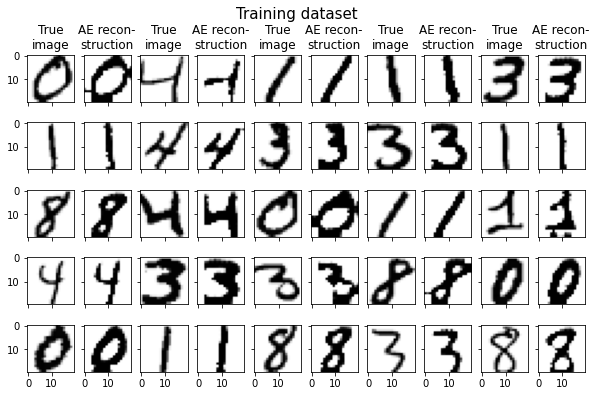

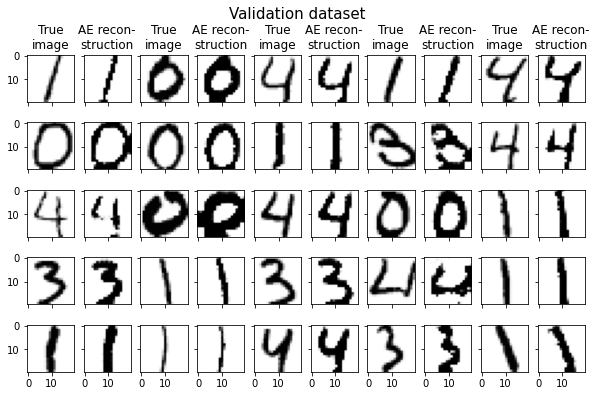

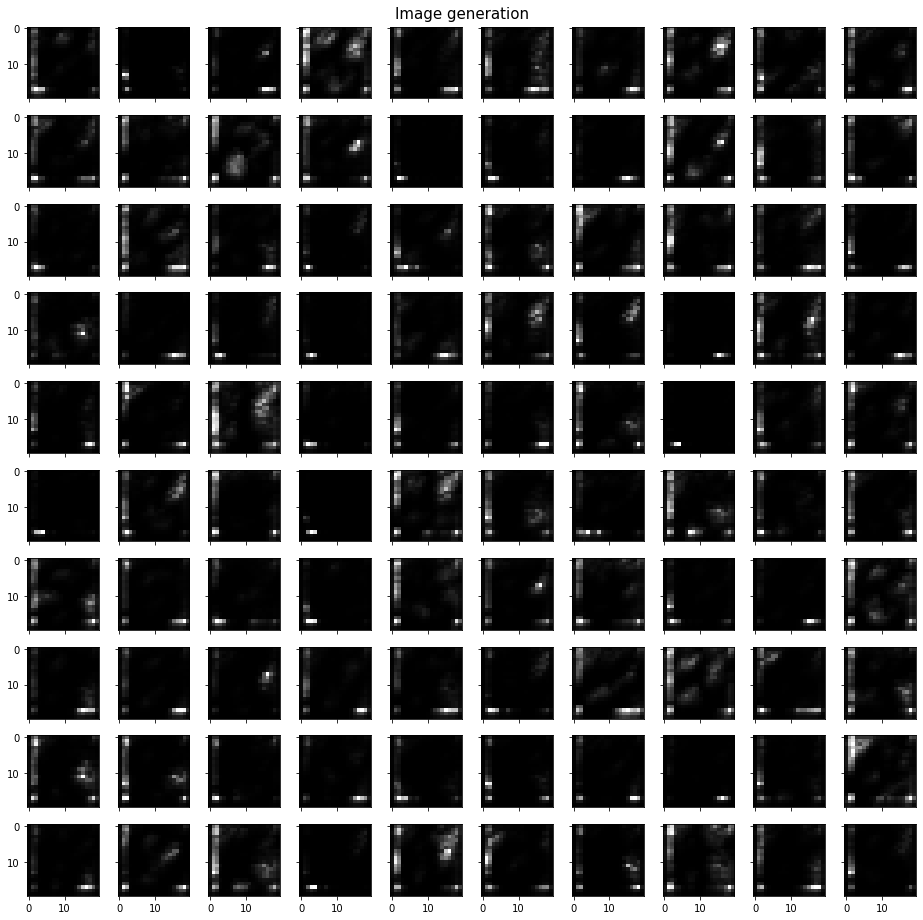

In [26]:
vae.to(device=torch.device('cpu')) 
fig, axs = plot_true_VS_reconstructed(vae, imgs_train)
fig.suptitle("Training dataset", fontsize=15)
plt.show()
fig, axs = plot_true_VS_reconstructed(vae, imgs_val)
fig.suptitle("Validation dataset", fontsize=15)
plt.show()
fig, axs = plot_generated_images(vae)
plt.show()

### Example training loss

![Example of VAE training loss with the KLD weight term (see VAE_training_loss image)](./VAE_training_loss.png)

![Example of VAE training loss with the KLD weight term (see VAE_training_loss_end image)](./VAE_training_loss_end.png)

--------------------
## TODO
Analyse the results in the 2 images above.

1. Compare the evolution of the MSE loss with the KL-divergence loss and comment. Both MSE loss and KL-divergence stagnate at relatively high values
2. By looking at the loss what type of results do you expect? (Good reconstruction? Good distribution in the latent space?) I expect allright generations, though nothing great as training loss is still higher than 0.6.
3. Recalling that for this assignment (and in its specific settings) we can say that our VAE learns well how to reconstruct if its training loss is lower than 0.6, would you say that the VAE is able to reconstruct well our data? 

### Example reconstruction
![Example of VAE reconstruction results on the training dataset with the KLD weight term (see VAE_train_reconstruction image)](./VAE_train_reconstruction.png)

--------------------
## TODO
Analyse the results in the image above.

1. Comment the behavior of the VAE when reconstructing different images. The vae is confused by similar digits (3s and 8s). There is a clear loss of features, but it still performs relatively well.

### Example generation
![Example of VAE generation results with the KLD weight term (see VAE_generation image)](./VAE_generation.png)

--------------------
## TODO
Analyse the results in the image above.

1. Do the generated images look similar to the outputs of the reconstructed images? Yes. The generated digits suffer from the same loss of features as the reconstructed ones.
1. Would you say that the VAE learnt well the parameters of a normal distribution? Sure